In [110]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpyro
import numpyro.distributions as dist
import seaborn as sns
from celluloid import Camera
from jax import random, vmap
from numpyro.infer import MCMC


# Plotting Functions and utilities

In [111]:
def plot_sample_density_vs_truth(samples, truth="banana", show_samples=False , save_path=None , title="Sample Density vs True Posterior"):
    x = samples["x"]
    y = samples["y"]

    # 2D density estimate from samples

    # Create grid for true posterior
    grid_x = jnp.linspace(-4, 4, 300)
    grid_y = jnp.linspace(-4, 4, 300)
    X, Y = jnp.meshgrid(grid_x, grid_y)

    if truth == "banana":

        def log_prob(x, y):
            return dist.Normal(0, 1.5).log_prob(x) + dist.Normal(0.1 * x**2, 0.5).log_prob(y)
    elif truth == "gaussian":

        def log_prob(x, y):
            return dist.Normal(0, 1).log_prob(x) + dist.Normal(0, 1).log_prob(y)
    else:
        raise ValueError("truth must be 'banana' or 'gaussian'")

    # Compute true density
    Z = vmap(vmap(log_prob))(X, Y)
    Z = jnp.exp(Z - Z.max())  # normalize

    # Plot comparison
    fig, ax = plt.subplots(figsize=(6, 6))

    if show_samples:
        sns.scatterplot(x=x, y=y, alpha=0.4, label="Samples", s=10)

    # Contour of true distribution
    ax.contour(X, Y, Z, levels=10, cmap="viridis", linewidths=1.2, alpha=0.6, label="True Density")

    # Contour from KDE estimate
    sns.kdeplot(
        x=x,
        y=y,
        fill=False,
        levels=10,
        color="red",
        linewidths=1,
        label="Estimated from Samples",
        ax=ax,
    )

    ax.set_title(title)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.legend()
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=600 , transparent=True)
    else:
        plt.show()

In [112]:
def animate_sample_scatter(samples, truth="banana", step=5, save_path=None , title="Posterior Samples"):

    x = samples["x"]
    y = samples["y"]

    grid_x = jnp.linspace(-4, 4, 300)
    grid_y = jnp.linspace(-4, 4, 300)
    X, Y = jnp.meshgrid(grid_x, grid_y)

    # True density
    if truth == "banana":

        def log_prob(x, y):
            return dist.Normal(0, 1.5).log_prob(x) + dist.Normal(0.1 * x**2, 0.5).log_prob(y)
    elif truth == "gaussian":

        def log_prob(x, y):
            return dist.Normal(0, 1).log_prob(x) + dist.Normal(0, 1).log_prob(y)
    else:
        raise ValueError("truth must be 'banana' or 'gaussian'")

    Z_true = vmap(vmap(log_prob))(X, Y)
    Z_true = jnp.exp(Z_true - Z_true.max())  # normalize

    # Set up figure and camera
    fig, ax = plt.subplots(figsize=(6, 6))
    camera = Camera(fig)

    # Animate samples over line contour background
    for i in range(1, len(x) + 1, step):
        # Line contour (not filled) — draw in every frame to preserve background
        ax.contour(X, Y, Z_true, levels=10, cmap="viridis", linewidths=1.2, alpha=0.6)

        # Scatter samples
        sns.scatterplot(x=x[:i], y=y[:i], s=10, color="black", ax=ax, alpha=0.6)

        # Step label
        ax.text(
            -3.8,
            3.5,
            f"Step: {i}",
            fontsize=10,
            bbox=dict(facecolor="white", edgecolor="gray", alpha=0.7),
        )

        ax.set_xlim(-4, 4)
        ax.set_ylim(-4, 4)
        ax.set_title(title)
        ax.set_xlabel("x")
        ax.set_ylabel("y")

        camera.snap()

    anim = camera.animate()

    if save_path:
        anim.save(save_path, writer="imagemagick", fps=20 , savefig_kwargs={"transparent": True })
    else:
        return anim

In [113]:
# Define models
def banana_model():
    x = numpyro.sample("x", dist.Normal(0, 1.5))
    y = numpyro.sample("y", dist.Normal(0.1 * x**2, 0.5))  # noqa : F841


def gaussian_model():
    x = numpyro.sample("x", dist.Normal(0, 1)) # noqa : F841
    y = numpyro.sample("y", dist.Normal(0, 1)) # noqa : F841


# Run MCMC
def run_custom_sampler(
    kernel_class,
    posterior="banana",
    init_loc="center",  # or "far"
    num_samples=500,
    num_warmup=1000,
    rng_seed=0,
):
    rng_key = random.PRNGKey(rng_seed)

    # Select model
    if posterior == "banana":
        model = banana_model
        init_position = {"x": 0.0, "y": 0.0} if init_loc == "center" else {"x": 10.0, "y": 10.0}
    elif posterior == "gaussian":
        model = gaussian_model
        init_position = {"x": 0.0, "y": 0.0} if init_loc == "center" else {"x": 5.0, "y": -5.0}
    else:
        raise ValueError("posterior must be either 'banana' or 'gaussian'")

    # Initialize kernel and MCMC
    kernel = kernel_class(model)
    mcmc = MCMC(kernel, num_samples=num_samples, num_warmup=num_warmup)
    mcmc.run(rng_key, init_params=init_position, extra_fields=("accept_prob",))

    return mcmc

# Running samples

In [92]:
hmc_banana = run_custom_sampler(
    kernel_class=numpyro.infer.NUTS,
    posterior="banana",
    init_loc="center",
    num_samples=500,
    num_warmup=1000,
    rng_seed=0,
)

mcmc_banana = run_custom_sampler(
    kernel_class=numpyro.infer.SA,
    posterior="banana",
    init_loc="center",
    num_samples=500,
    num_warmup=1000,
    rng_seed=0,
)

hmc_gaussian = run_custom_sampler(
    kernel_class=numpyro.infer.NUTS,
    posterior="gaussian",
    init_loc="center",
    num_samples=500,
    num_warmup=1000,
    rng_seed=0,
)

mcmc_gaussian = run_custom_sampler(
    kernel_class=numpyro.infer.SA,
    posterior="gaussian",
    init_loc="center",
    num_samples=500,
    num_warmup=1000,
    rng_seed=0,
)

sample: 100%|██████████| 1500/1500 [00:01<00:00, 918.74it/s, acc. prob=0.57] 


# Plotting

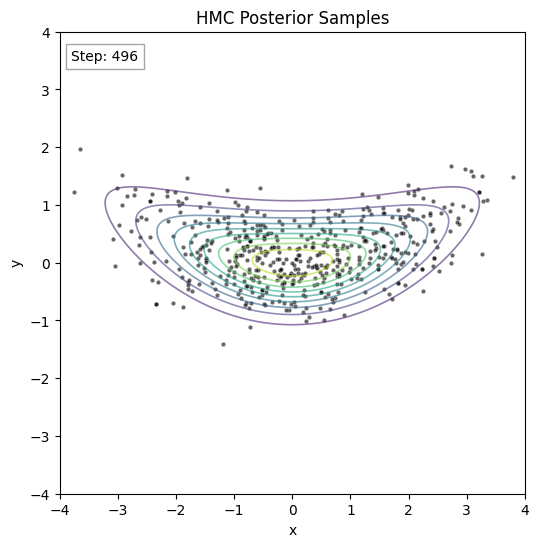

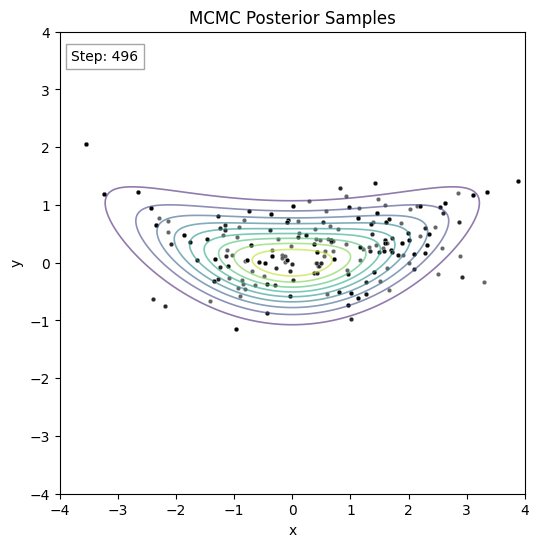

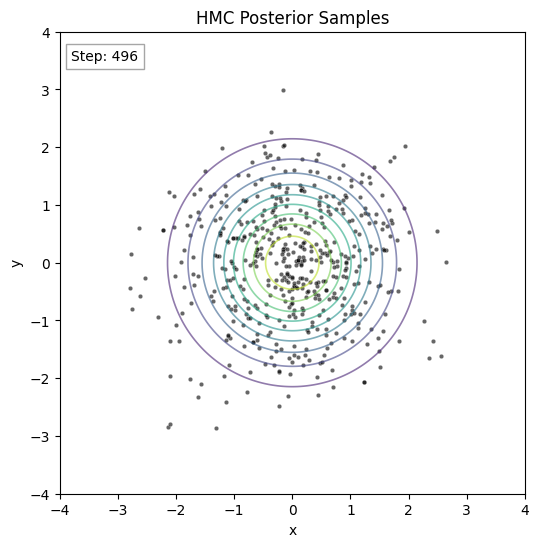

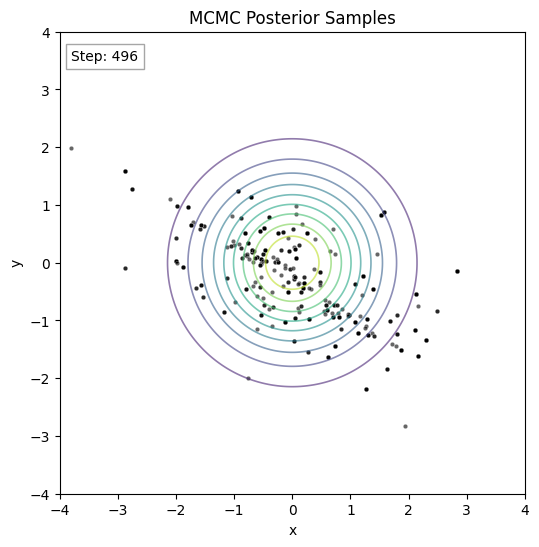

In [114]:
animate_sample_scatter(hmc_banana.get_samples(), truth="banana", save_path="banana_hmc.gif" , title="HMC Posterior Samples")
animate_sample_scatter(mcmc_banana.get_samples(), truth="banana", save_path="banana_mcmc.gif" , title="MCMC Posterior Samples")
animate_sample_scatter(hmc_gaussian.get_samples(), truth="gaussian", save_path="gaussian_hmc.gif" , title="HMC Posterior Samples")
animate_sample_scatter(mcmc_gaussian.get_samples(), truth="gaussian", save_path="gaussian_mcmc.gif" , title="MCMC Posterior Samples")

/tmp/ipykernel_48454/1634803154.py:34: UserWarning: The following kwargs were not used by contour: 'label'
  ax.contour(X, Y, Z, levels=10, cmap="viridis", linewidths=1.2, alpha=0.6, label="True Density")
/tmp/ipykernel_48454/1634803154.py:34: UserWarning: The following kwargs were not used by contour: 'label'
  ax.contour(X, Y, Z, levels=10, cmap="viridis", linewidths=1.2, alpha=0.6, label="True Density")
/tmp/ipykernel_48454/1634803154.py:34: UserWarning: The following kwargs were not used by contour: 'label'
  ax.contour(X, Y, Z, levels=10, cmap="viridis", linewidths=1.2, alpha=0.6, label="True Density")
/tmp/ipykernel_48454/1634803154.py:34: UserWarning: The following kwargs were not used by contour: 'label'
  ax.contour(X, Y, Z, levels=10, cmap="viridis", linewidths=1.2, alpha=0.6, label="True Density")


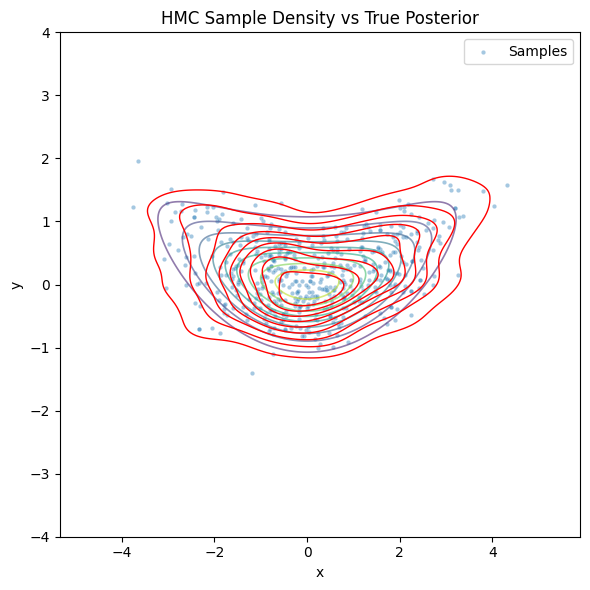

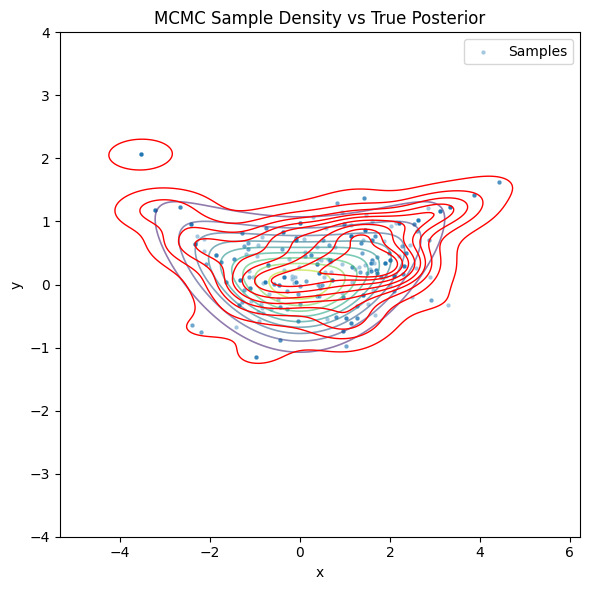

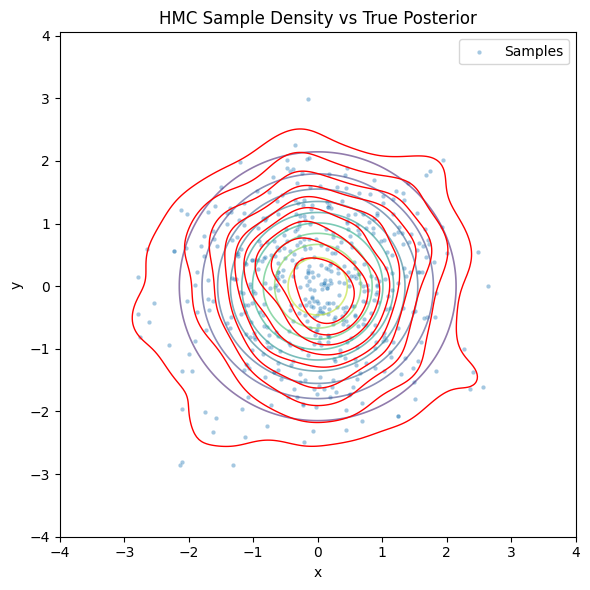

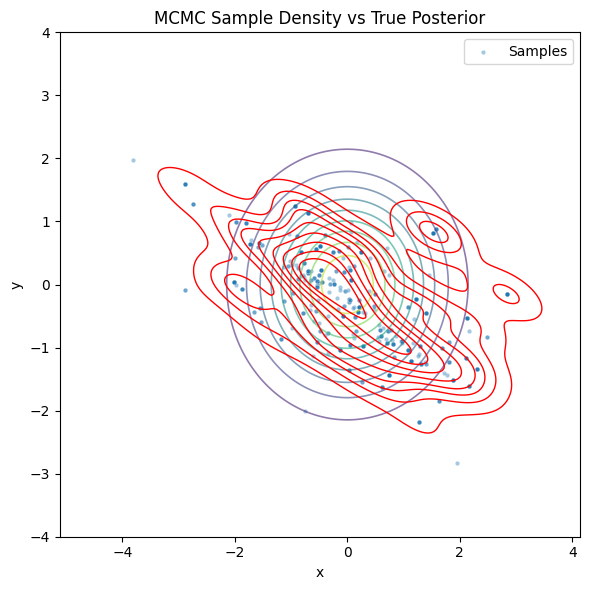

In [115]:
plot_sample_density_vs_truth(hmc_banana.get_samples(), truth="banana", show_samples=True, title="HMC Sample Density vs True Posterior",save_path="banana_hmc_density.png")
plot_sample_density_vs_truth(mcmc_banana.get_samples(), truth="banana", show_samples=True, title="MCMC Sample Density vs True Posterior",save_path="banana_mcmc_density.png")
plot_sample_density_vs_truth(hmc_gaussian.get_samples(), truth="gaussian", show_samples=True, title="HMC Sample Density vs True Posterior",save_path="gaussian_hmc_density.png")
plot_sample_density_vs_truth(mcmc_gaussian.get_samples(), truth="gaussian", show_samples=True, title="MCMC Sample Density vs True Posterior",save_path="gaussian_mcmc_density.png")

 # Gradient effects

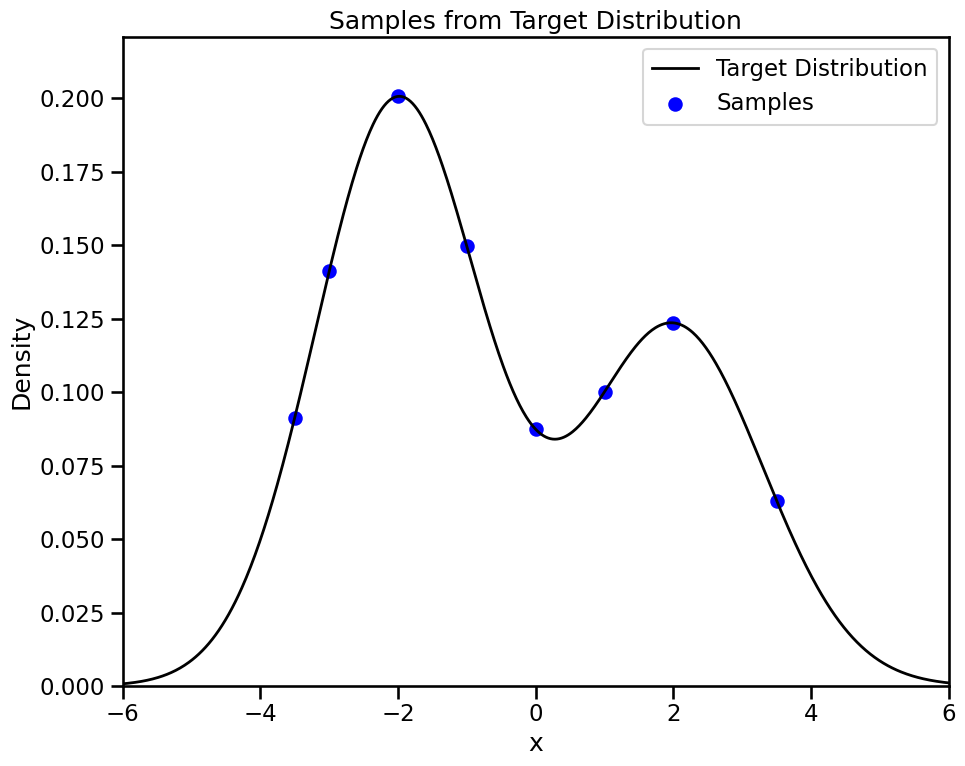

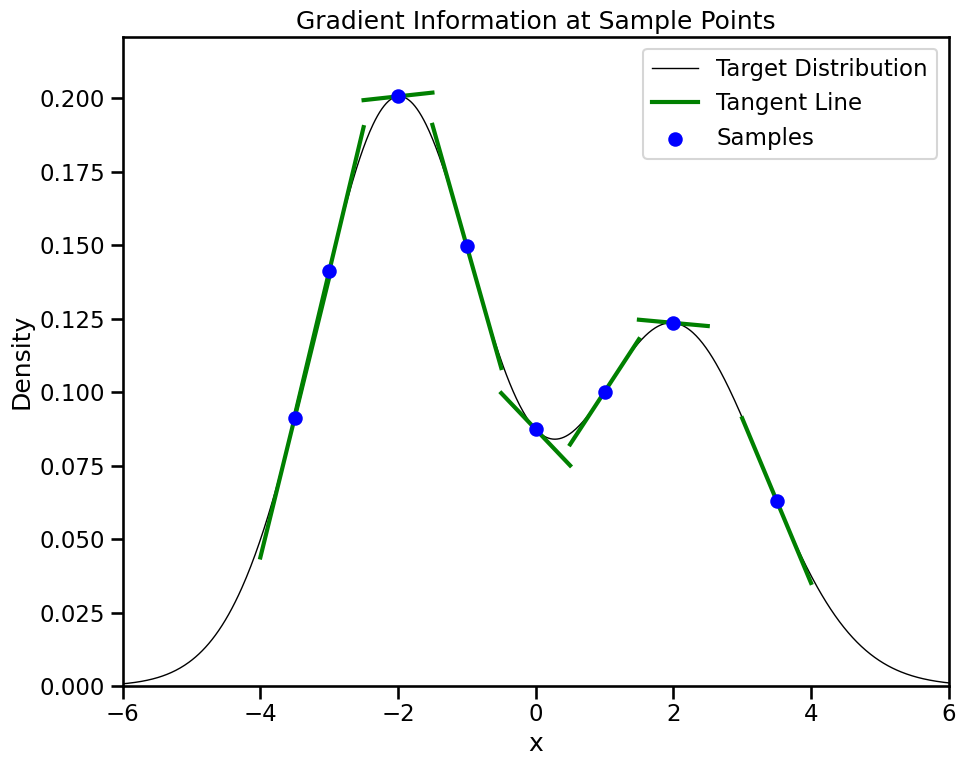

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns
sns.set_context('talk')


# Define target distribution: mixture of Gaussians
def target_pdf(x):
    return 0.6 * norm.pdf(x, loc=-2, scale=1.2) + 0.4 * norm.pdf(x, loc=2, scale=1.3)

def target_logpdf(x):
    return np.log(target_pdf(x))

def target_grad(x, eps=1e-5):
    return (target_pdf(x + eps) - target_pdf(x - eps)) / (2 * eps)


# Shared data
x = np.linspace(-8, 8, 1000)
pdf_vals = target_pdf(x)

# Select well-separated sample points
samples = np.array([-3.5, -3.0, -2.0,-1.0, 0.0,1.0 , 2.0, 3.5])  # Chosen to span both modes

# Axis limits
xlim = (-6, 6)
ylim = (0, np.max(pdf_vals) * 1.1)

# === Figure 1: Samples Only ===
plt.figure(figsize=(10, 8))
plt.plot(x, pdf_vals, color='black', lw=2, label='Target Distribution')
plt.scatter(samples, target_pdf(samples), color='blue', s=80, label='Samples')
plt.title("Samples from Target Distribution")
plt.xlabel("x")
plt.ylabel("Density")
plt.xlim(xlim)
plt.ylim(ylim)
plt.legend()
plt.tight_layout()
plt.savefig("samples_only.png", dpi=600 , transparent=True)
plt.show()

# === Figure 2: With Gradient Info ===
plt.figure(figsize=(10, 8))
plt.plot(x, pdf_vals, color='black', lw=1, label='Target Distribution')
for i , s in enumerate(samples):
    y = target_pdf(s)
    grad = target_grad(s)
    dx = 0.5  # Range for tangent line
    tangent_x = np.linspace(s - dx, s + dx, 10)
    tangent_y = y + grad * (tangent_x - s)
    if i == 0:
      plt.plot(tangent_x, tangent_y, color='green', lw=3 , label='Tangent Line')  # Thicker lines
      plt.scatter(s, y, color='blue', s=80, zorder=5 , label='Samples')  # Higher zorder for samples
    else:
      plt.plot(tangent_x, tangent_y, color='green', lw=3)
      plt.scatter(s, y, color='blue', s=80, zorder=5)
plt.title("Gradient Information at Sample Points")
plt.xlabel("x")
plt.ylabel("Density")
plt.xlim(xlim)
plt.ylim(ylim)
plt.legend()
plt.tight_layout()
plt.savefig("samples_with_gradients.png", dpi=600 , transparent=True)
plt.show()



sample: 100%|██████████| 1500/1500 [00:04<00:00, 357.22it/s, 7 steps of size 8.59e-01. acc. prob=0.90]


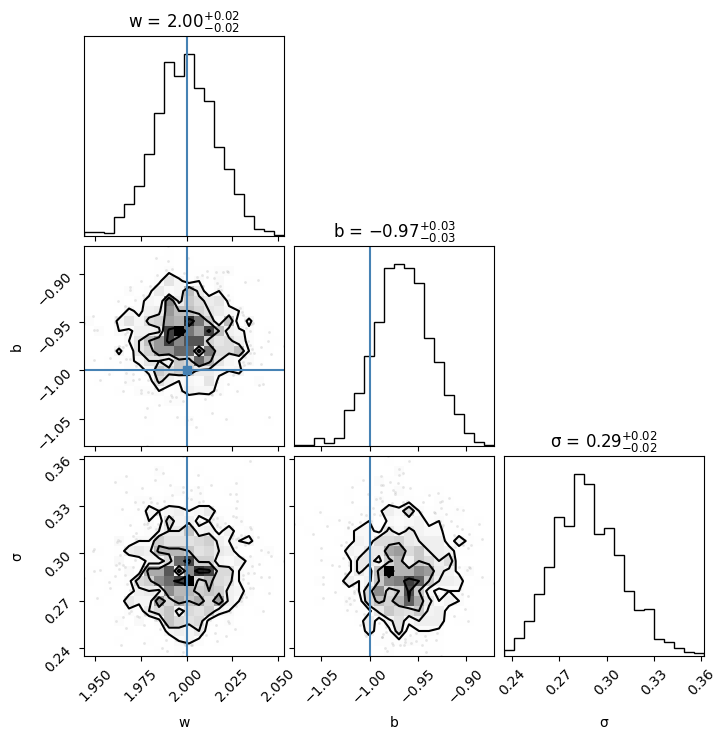

In [5]:
import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
import matplotlib.pyplot as plt
import arviz as az
import corner

# -------------------------------
# Step 1: Generate synthetic data
# -------------------------------
true_w = 2.0
true_b = -1.0
num_points = 100

rng_key = jax.random.PRNGKey(0)
x_data = jnp.linspace(-3, 3, num_points)
noise = jax.random.normal(rng_key, shape=(num_points,)) * 0.3
y_data = true_w * x_data + true_b + noise

# -------------------------------
# Step 2: Define NumPyro model
# -------------------------------
def linear_regression(x, y=None):
    w = numpyro.sample("w", dist.Normal(0, 1))
    b = numpyro.sample("b", dist.Normal(0, 1))
    sigma = numpyro.sample("sigma", dist.Exponential(1.0))

    mean = w * x + b
    numpyro.sample("obs", dist.Normal(mean, sigma), obs=y)

# -------------------------------
# Step 3: Run inference with NUTS
# -------------------------------
kernel = numpyro.infer.NUTS(linear_regression)
mcmc = numpyro.infer.MCMC(kernel, num_warmup=500, num_samples=1000)
mcmc.run(rng_key, x=x_data, y=y_data)
idata = az.from_numpyro(mcmc)

# -------------------------------
# Step 4: Posterior corner plot using arviz + corner
# -------------------------------
# Convert to (n_samples, n_vars) array for corner
posterior_array = az.extract(idata, var_names=["w", "b", "sigma"]).to_array().values.T

fig = corner.corner(
    posterior_array,
    labels=["w", "b", "σ"],
    truths=[true_w, true_b, None],
    show_titles=True
)
plt.show()


In [22]:
import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
import matplotlib.pyplot as plt
import arviz as az
import corner
import  blackjax 
from numpyro.infer.util import initialize_model

# -------------------------------
# Step 1: Generate synthetic data
# -------------------------------
true_w = 2.0
true_b = -1.0
n = 100

rng_key = jax.random.PRNGKey(0)
x_data = jnp.linspace(-3, 3, n)
noise = jax.random.normal(rng_key, shape=(n,)) * 0.3
y_data = true_w * x_data + true_b + noise

# -------------------------------
# Step 2: Define NumPyro model
# -------------------------------
def model(x, y=None):
    w = numpyro.sample("w", dist.Normal(0, 1))
    b = numpyro.sample("b", dist.Normal(0, 1))
    sigma = numpyro.sample("sigma", dist.Exponential(1.0))
    mu = w * x + b
    numpyro.sample("obs", dist.Normal(mu, sigma), obs=y)

# -------------------------------
# Step 3: Set up BlackJAX NUTS
# -------------------------------
rng_key, init_key = jax.random.split(rng_key)
init_params, potential_fn, *_ = initialize_model(
    init_key,
    model,
    model_args=(x_data,),
    model_kwargs={"y": y_data},
    dynamic_args=True
)

logdensity_fn = lambda position: -potential_fn(x_data, y=y_data)(position)
initial_position = init_params.z

# Adapt step size and inverse mass matrix
num_warmup = 2000
adapt = blackjax.window_adaptation(blackjax.nuts, logdensity_fn, target_acceptance_rate=0.8)
rng_key, warmup_key = jax.random.split(rng_key)
(last_state, parameters), _ = adapt.run(warmup_key, initial_position, num_warmup)
kernel = blackjax.nuts(logdensity_fn, **parameters).step

# Run final NUTS with adapted parameters

def run_blackjax_sampling(rng_key, state, kernel, num_samples=1000):
    def one_step(state, key):
        state, info = kernel(key, state)
        return state, state

    keys = jax.random.split(rng_key, num_samples)
    _, samples = jax.lax.scan(one_step, state, keys)
    return samples

samples = run_blackjax_sampling(rng_key, last_state, kernel)
idata = az.from_dict(posterior=samples.position)

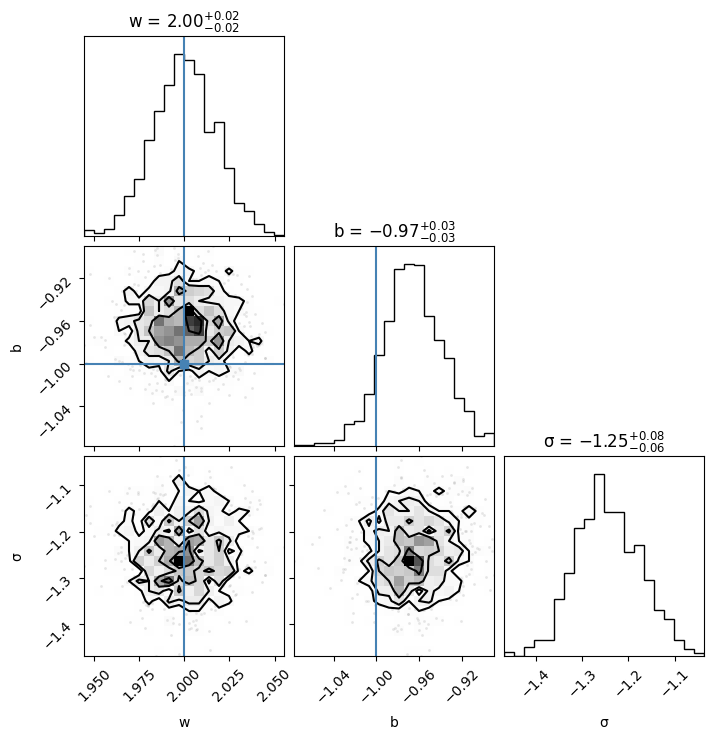

In [23]:
posterior_array = az.extract(idata, var_names=["w", "b", "sigma"]).to_array().values.T

fig = corner.corner(
    posterior_array,
    labels=["w", "b", "σ"],
    truths=[true_w, true_b, None],
    show_titles=True
)